<a href="http://landlab.github.io"><img style="float: left" src="https://raw.githubusercontent.com/landlab/tutorials/master/landlab_header.png"></a>

# Exploring overland flow routing with Landlab

## Objectives
* Introduce the Shallow Water Equation, Test Area, Model Steps, and Curriculum Questions.
* Use Landlab to set up a comparative model experiment.
* Run a Landlab model.
* Explore flow sensitivity using model results.
* Save results to a new HydroShare resource.

## About this notebook

### Data Science and Cyberinfrastructure

This notebook is a computational narrative using the [Landlab](http://landlab.github.io) Python-based modeling toolkit that allows scientists and students to build numerical landscape models. This notebook also utilizes the following open source research software libraries: [NumPy](http://www.numpy.org), [Matplotlib](https://matplotlib.org), [Pandas](https://pandas.pydata.org), and [HydroShare](https://www.hydroshare.org). The software environment is provided by the [CUAHSI JupyterHub server](https://jupyter.cuahsi.org). 
<hr>

**[Click here for additional Landlab tutorials](https://github.com/landlab/landlab/wiki/Tutorials)**
<hr>

### How to use this notebook

#### Navigation

This notebook is made of text cells, including the cell you are reading now, and code cells. The order in which you run the cells matters. The notebook cells are generally designed to be run top to bottom.

Code cells have the following characters to their left:
* `In [ ]:` is a cell yet to be run.
* `In [*]:` is a cell that is running.
* `In [n]:` where `n` is an integer, is a cell that has run. The number indicates the sequence the cell was run, i.e. the first cell run is `n`=1.

The code in a notebook is ran one cell at a time. Place your cursor in a code cell, hold down `shift` and then also press `enter`. You can even experiment with typing your own code into a cell and running that.

Alternatively, you can run groups of cells by clicking `Cell` on the menu above and then selecting among the various run options. This is also where you can clear outputs from previous runs.

You can also `shift` + `enter` in a text cell to advance your place in the notebook.

See [this page](https://github.com/landlab/tutorials/blob/master/README.md) for more instructions on how to use an interactive Jupyter notebook.

#### Output

Every time you run this notebook the model outputs you generate are saved in your personal user space in the virtual computer through Hydroshare. These outputs are available for you to plot and explore using the plotting functions. We will plot model output at the end of this tutorial. 

Your final results can be saved to Hydroshare as a resource (see section 9.0 below). Unwanted model output can be deleted at anytime from your space, including by running the final code block of this tutorial. 

If an error occurs, click on the upper menu bar item, `Kernal` and then select `Restart and Clear Outputs` in the drop down menu.

### Acknowledgements

This notebook was developed from code written by Jordan Adams as part of her Ph.D. disseration at Tulane University and Amanda Manaster as a tutorial for a Landlab workshop at the Geophysical Society of America Annual Meeting, Seattle, WA, 2018. Nathan Lyons provided code and technical support on animations.   

Use or citation of this notebook should also reference:

Adams, J. M., Gasparini, N. M., Hobley, D. E. J., Tucker, G. E., Hutton, E. W. H., Nudurupati, S. S., and Istanbulluoglu, E.: The Landlab v1.0 OverlandFlow component: a Python tool for computing shallow-water flow across watersheds, Geosci. Model Dev., 10, 1645-1663, https://doi.org/10.5194/gmd-10-1645-2017, 2017.

## 1.0. Introduction

### 1.1. Theory

The 1-D Saint Venant equation for transient shallow water flow is in the core of most hydrodynamics models:

$$ \frac{\partial Q}{\partial t} + \frac{\partial}{\partial x}\left(\frac{Q^2}{A_{xs}}\right) + gA_{xs} \frac{\partial (h+z)}{\partial x} + \frac{gn^2 \lvert{Q}\rvert Q}{R^{4/3}A_{xs}} = 0 \space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space(1)$$
    


where      
&nbsp;&nbsp;&nbsp;&nbsp;$Q = discharge \left[L^3{T^{-1}}\right]$  
&nbsp;&nbsp;&nbsp;&nbsp;$t = time \left[T\right]$  
&nbsp;&nbsp;&nbsp;&nbsp;$x = location \space in \space space \left[L\right]$   
&nbsp;&nbsp;&nbsp;&nbsp;$g = acceleration \space due \space to \space gravity \left[L{T^{-2}}\right]$  
&nbsp;&nbsp;&nbsp;&nbsp;$h = water \space depth \left[L\right]$  
&nbsp;&nbsp;&nbsp;&nbsp;$z = bed \space elevation \left[L\right]$  
&nbsp;&nbsp;&nbsp;&nbsp;$n = Manning's \space roughness \space coeffiecient \left[T{L^{{-1}/{3}}}\right]$  
&nbsp;&nbsp;&nbsp;&nbsp;$R = hydraulic \space radius \left[L\right]$  
&nbsp;&nbsp;&nbsp;&nbsp;$A_{xs} = cross-sectional \space area \left[L^2\right]$ 

From left to right, the terms in Equation (1) represent local acceleration, convective acceleration, gradients of fluid pressure and bed elevation, and friction. Because this equation is difficult (i.e., almost impossible) to solve explicitly, approximations are commonly used. The simplest approximation, the Kinematic Wave model, only retains the friction term, making it the simplest approximation one can use. The Landlab `KinwaveImplicitOverlandFlow` component provides a 2-D locally implicit kinematic wave solution in which energy slope is assumed to be equal to the bed slope. 

The diffusive model developed from Equation (1) neglects the first two terms. The Landlab `OverlandFlow` component (Adams et al. 2017) adapts a 2D hydrodynamic algorithm similar to the diffusive approximation with negligible advection term (de Almeida et al., 2012) used in LISFLOOD-FP. The flow geometry is assumed to be rectangular and of constant flow width. The approximation used in `OverlandFlow` is more accurate but also more computationally expensive than the approximation used in `KinwaveImplicitOverlandFlow`.  

<small>Click here for the OverlandFlow Component Users Manual: https://github.com/landlab/landlab/wiki/OverlandFlow-Component-Users-Manual</a></small><br>

This tutorial illustrates the use of both the `KinwaveImplicitOverlandFlow` and the `OverlandFlow` components to map overland flow depth across two modeling domains and plot a flow hydrograph at the outlet and several internal nodes. We will use two domains:

* Spring Creek watershed, CO, USA 
* A synthetic landscape modeled with Landlab   

We will investigate the roles of watershed shape and runoff intensity and duration on the characteristics of hydrographs. Runoff is assumed to be generated at a spatially constant rate on the landscape and flows downhill, driving overland flow and a hydrograph at every location on the landscape. 

**Terms:** runoff intensity, runoff duration, peak discharge, hydrograph time to peak, rising limb, falling limb. 

### 1.2. Model Domains 

The natural catchment used in this tutorial and studied in Adams et al. (2017) is the Spring Creek watershed, a steep 27 km$^2$ watershed located in central Colorado. The digital elevation model (DEM) we will use has a resolution of 30 meters. To clearly contrast landscape shape, this notebook uses a modeled "synthetic" landscape produced using a model developed in Landlab by coupling hillslope diffusion and stream-power erosion rules. The landscape evolution model was run on a 36 km$^2$ area represented by regular grids with a node spacing of 30 m. 

These watershed domains are available at the Landlab Github site and as Hydroshare resources, and will be imported as part of this exercise.

### 1.3. Steps to Explore the Model

We will run the two overland flow models for 6 hours. A storm begins at the onset of the simulation and lasts for 2 hours. We will visualize water depths across the watershed over the course of the simulation and plot hydrographs at the outlet and two internal nodes.

In repeated model experiments you can investigate the influence of runoff intensity, runoff duration, and surface resistance on streamflow hydrographs. You can organize your approach by running the two models and saving results from each watershed domain before running the models for the other domain.  

Revisit the 'How to use this notebook' section at the top of the page as needed.

### 1.4. Questions to consider before running this notebook

We will focus on the hydrograph characteristics, time to peak, peak discharge, and hydrograph shape. 

1. How do watershed shape and drainage area affect hydrograph characteristics? 
2. How does runoff intensity impact the time to peak and peak discharge across the channel network? 
3. How does runoff duration impact the time to peak and peak discharge across the channel network? 
4. How does surface roughness due to soil and land cover influence hydrograph peak discharge and shape?

## 2.0 Data Science & Cyberinfrastructure Methods

### 2.1 Import Landlab components and additional modules

In [1]:
from landlab.components import OverlandFlow
from landlab.components import KinwaveImplicitOverlandFlow
from landlab.io import read_esri_ascii
from landlab import imshow_grid
from landlab.components.flow_accum import flow_accumulation
from landlab.components.flow_accum import find_drainage_area_and_discharge
from landlab.components.flow_accum import FlowAccumulator

### 2.2 Import standard,  plotting, and numeric modules

In [2]:
import copy
import os

from IPython.display import HTML
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mgimg

import numpy as np
import pandas as pd

# Set the environment to place plots in Jupyter cells.
%matplotlib inline

### 2.3 Import HydroShare tools

The results of the Geoprocessing steps below will be saved in the HydroShare environment using the `hydroshare` library. These are needed to import data from HydroShare and create new HydroShare resources with your results.

In [3]:
from utilities import hydroshare

hs = hydroshare.hydroshare()
print('This is the list of folders in your directory of this HydroShare resource.')
os.getcwd()

Adding the following system variables:
   HS_USR_NAME = ChristinaBandaragoda
   HS_RES_ID = 70b977e22af544f8a7e5a803935c329c
   HS_RES_TYPE = genericresource
   JUPYTER_HUB_IP = jupyter.cuahsi.org

These can be accessed using the following command: 
   os.environ[key]

   (e.g.)
   os.environ["HS_USR_NAME"]  => ChristinaBandaragoda
Successfully established a connection with HydroShare
This is the list of folders in your directory of this HydroShare resource.


'/home/jovyan/work/notebooks/data/70b977e22af544f8a7e5a803935c329c/70b977e22af544f8a7e5a803935c329c/data/contents'

## 3.0 Landlab Methods

### 3.1. Use Landlab to read in the ASCII DEM and set boundary conditions 

In [15]:
# Square Basin
watershed_dem_sq = 'supporting_files/Square_TestBasin.asc'
(rmg_sq, z_sq) = read_esri_ascii(watershed_dem_sq, name='topographic__elevation')
rmg_sq.set_watershed_boundary_condition(z_sq)

# Spring Creek Basin
watershed_dem_sc = 'supporting_files/SpringCreek_DEM.asc'
(rmg_sc, z_sc) = read_esri_ascii(watershed_dem_sc, name='topographic__elevation')
rmg_sc.set_watershed_boundary_condition(z_sc)

### 3.2. Use Landlab to calculate flow accumulation and drainage area  

Drainage areas derived in this step will be used in selecting internal points for plotting hydrographs. 

In [16]:
# Square Basin
fa_sq = FlowAccumulator(rmg_sq)
fa_sq.run_one_step()
(da_sq, q_sq) = fa_sq.accumulate_flow()

# Spring Creek
fa_sc = FlowAccumulator(rmg_sc)
fa_sc.run_one_step()
(da_sc, q_sc) = fa_sc.accumulate_flow()

### 3.3. List and select the nodes with a drainage area greater than a threshold  

Below we show how you can identify internal nodes in the two domains for plotting streamflow hydrographs. We selected nodes such that the watershed areas above mid and upstream nodes of the two watersheds are close to each other. This gives us the opportunity to compare hydrographs in relation to watershed shape and watershed relief above each node, given the similar watershed area values.

The midstream and upstream node drainage area thresholds can be identified by drainage area ranges in km$^2$. The range used to identify a midstream location should be larger than the range used to identify an upstream location. These internal nodes can be identified by trial using different drainage area values, and plotting the locations selected. After we select the drainage area ranges we will print the node IDs, drainge areas, and elevations of the locations we select and map the locations on the elevation map of the watershed. To continue your project with the Square domain you can skip the steps in 2.5.2 that pertains to Spring Creek and move to 2.6. After modeling flows in the Square domain you will need to come back to 2.5.2. and identify the nodes you would like to include for hydrograph analysis in Spring Creek. 

#### 3.3.1 Square Basin: a) set thresholds and b) select output nodes

We will identify the nodes for the outlet, midstream, and upstream locations for plotting hydrographs using drainage area thresholds for the latter two. Code is written to set the outlet at the node with the largest drainage area. Below we will first identify the outlet node ID, its elevation and drainage area.  

In [17]:
outlet_node_to_sample_sq = np.argmax(rmg_sq.at_node['drainage_area'])

print('Outlet Node = ' + str(outlet_node_to_sample_sq) + '; Drainage Area = ' + str(da_sq[outlet_node_to_sample_sq] / 1000000) + ' km^2; Elev = '+ str(round(z_sq[outlet_node_to_sample_sq],1)) + ' m')

Outlet Node = 100; Drainage Area = 35.28 km^2; Elev = 0.0 m


In [18]:
# These values can be change to set drainage area thresholds in km^2
midstream_da_upperbound = 20
midstream_da_lowerbound = 12
upstream_da_upperbound = 4
upstream_da_lowerbound = 3

midstream_node_to_sample_sq = np.where(np.logical_and(rmg_sq.at_node['drainage_area'] > midstream_da_lowerbound * 1000000, rmg_sq.at_node['drainage_area'] < midstream_da_upperbound * 1000000))[0][-1]
upstream_node_to_sample_sq = np.where(np.logical_and(rmg_sq.at_node['drainage_area'] > upstream_da_lowerbound * 1000000, rmg_sq.at_node['drainage_area'] < upstream_da_upperbound * 1000000))[0][-1]

print('Outlet Node = ' + str(outlet_node_to_sample_sq) + '; Drainage Area= ' + str(da_sq[outlet_node_to_sample_sq] / 1000000) + ' km^2; Elev = '+ str(round(z_sq[outlet_node_to_sample_sq], 1)) + ' m')
print('Midstream Node = ' + str(midstream_node_to_sample_sq) + '; Drainage Area= ' + str(da_sq[midstream_node_to_sample_sq] / 1000000) + ' km^2; Elev = '+ str(round(z_sq[midstream_node_to_sample_sq], 1)) + ' m')
print('Upstream Node = ' + str(upstream_node_to_sample_sq) + '; Drainage Area= ' + str(da_sq[upstream_node_to_sample_sq] / 1000000) + ' km^2; Elev = '+ str(round(z_sq[upstream_node_to_sample_sq], 1)) + ' m')

Outlet Node = 100; Drainage Area= 35.28 km^2; Elev = 0.0 m
Midstream Node = 10502; Drainage Area= 18.3537 km^2; Elev = 7.3 m
Upstream Node = 31113; Drainage Area= 3.528 km^2; Elev = 38.4 m


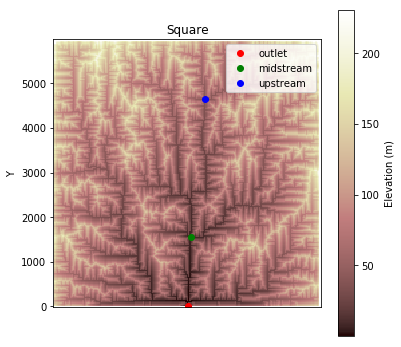

In [19]:
# Plot Square Basin

# set up the figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
ax.xaxis.set_visible(False)

# plot the DEM
imshow_grid(rmg_sq, z_sq, plot_name='Square', color_for_closed="white", colorbar_label='Elevation (m)')

# plot the sample nodes
ax.plot(rmg_sq.node_x[outlet_node_to_sample_sq], rmg_sq.node_y[outlet_node_to_sample_sq], 'ro', label='outlet')
ax.plot(rmg_sq.node_x[midstream_node_to_sample_sq], rmg_sq.node_y[midstream_node_to_sample_sq], 'go', label='midstream')
ax.plot(rmg_sq.node_x[upstream_node_to_sample_sq], rmg_sq.node_y[upstream_node_to_sample_sq], 'bo', label='upstream')

_ = ax.legend()

#### 3.3.2 Spring Creek: set thresholds and select the output nodes listed by threshold

We will identify the nodes for outlet, midstream, and upstream locations for plotting hydrographs using drainge area thresholds for the latter two. Code is written to set the outlet at the node with the largest drainage area. Below we will first identify the outlet node ID, its elevation and drainage area.


In [20]:
outlet_node_to_sample_sc = np.argmax(rmg_sc.at_node['drainage_area'])
print('Outlet Node = ' + str(outlet_node_to_sample_sc) + '; Drainage Area= ' + str(da_sc[outlet_node_to_sample_sc] / 1000000) + ' km^2; Elev = '+ str(round(z_sc[outlet_node_to_sample_sc], 1)) + ' m')

Outlet Node = 55472; Drainage Area= 26.7525 km^2; Elev = 1875.3 m


The midstream and upstream node drainge area thresholds can be identified by drainge area ranges in km$^2$. The range used to identify a midstream location should be larger than the range used to identify an upstream location. These internal nodes can be identified by trial using different drainge area values, and plotting the locations selected. After we select the drainage area ranges we will print the node IDs, drainge areas, and elevations of the locations we select and map the locations on the elevation map of the watershed. 

In [21]:
# These values can be change to set drainage area thresholds in km^2
midstream_da_upperbound = 20
midstream_da_lowerbound = 17.5
upstream_da_upperbound = 5
upstream_da_lowerbound = 3.2

# Identify sample nodes.
outlet_node_to_sample_sc = np.argmax(rmg_sc.at_node['drainage_area'])
midstream_node_to_sample_sc = np.where(np.logical_and(rmg_sc.at_node['drainage_area'] > midstream_da_lowerbound * 1000000, rmg_sc.at_node['drainage_area']<midstream_da_upperbound*1000000))[0][0]
upstream_node_to_sample_sc = np.where(np.logical_and(rmg_sc.at_node['drainage_area'] > upstream_da_lowerbound*1000000, rmg_sc.at_node['drainage_area']<upstream_da_upperbound*1000000))[0][0]

print('Outlet Node = ' + str(outlet_node_to_sample_sc) + '; Drainage Area= ' + str(da_sc[outlet_node_to_sample_sc] / 1000000) + ' km^2; Elev = '+ str(round(z_sc[outlet_node_to_sample_sc], 1)) + ' m')
print('Midstream Node = ' + str(midstream_node_to_sample_sc) + '; Drainage Area= ' + str(da_sc[midstream_node_to_sample_sc] / 1000000) + ' km^2; Elev = '+ str(round(z_sc[midstream_node_to_sample_sc], 1)) + ' m')
print('Upstream Node = ' + str(upstream_node_to_sample_sc) + '; Drainage Area= ' + str(da_sc[upstream_node_to_sample_sc] / 1000000) + ' km^2; Elev = '+ str(round(z_sc[upstream_node_to_sample_sc], 1)) + ' m')

Outlet Node = 55472; Drainage Area= 26.7525 km^2; Elev = 1875.3 m
Midstream Node = 47742; Drainage Area= 18.7497 km^2; Elev = 2062.2 m
Upstream Node = 19131; Drainage Area= 3.2094 km^2; Elev = 2243.2 m


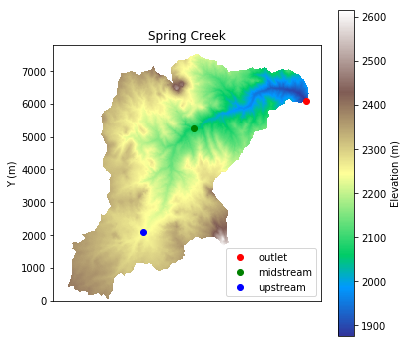

In [22]:
## Plot Spring Creek

# Set up the figure.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
ax.xaxis.set_visible(False)

# Plot the DEM.
imshow_grid(rmg_sc, z_sc, plot_name='Spring Creek', var_name='Elevation', var_units='m', grid_units=('m', 'm'), 
            cmap='terrain', limits=(1875, 2615), color_for_closed='white')
ax.set_facecolor("white")

# Plot the sample nodes.
ax.plot(rmg_sc.node_x[outlet_node_to_sample_sc], rmg_sc.node_y[outlet_node_to_sample_sc], 'ro', label='outlet')
ax.plot(rmg_sc.node_x[midstream_node_to_sample_sc], rmg_sc.node_y[midstream_node_to_sample_sc], 'go', label='midstream')
ax.plot(rmg_sc.node_x[upstream_node_to_sample_sc], rmg_sc.node_y[upstream_node_to_sample_sc], 'bo', label='upstream')

_ = ax.legend(loc='lower right')

<hr>

# 4.0. Make Model Decisions 

We used the following runoff categories for this exercise, which can be changed by the user: 
  * `Base` has an intensity of 5.0 mm/hr, with a duration of 2 hr.
  * `HigherIntensity` has an intensity of 10.0 mm/hr, with a duration of 2 hr.
  * `LongerDuration` has an intensity of 5.0 mm/hr, with a duration of 4 hr. Longer duration is hardcoded as twice the storm duration of the base case. However it can be changed.
 
 Below you will indicate the domain, storm category, and algorithm you would like to use. You can change the runoff generation intesity and duration. Note that time is given in hours, and the model is run in *seconds*
 
**Change your model with the options below**

In [45]:
basin_flag = 'Spring Creek'      # 'Square' or 'Spring Creek'
storm_flag = 'HigherIntensity'   # 'Base' or'HigherIntensity' or 'LongerDuration'
routing_method = 'OverlandFlow'  # use 'OverlandFlow' OR 'KinwaveImplicitOverlandFlow'  

Advanced users only: if you know what you are doing, change the options below. 

In [46]:
image_save = 1                  # 1: save image; 0: don't save
hours = 6                       # hours of model run time
Number_frames = 6               # number of frames to plot
n = 0.03                        # Manning's roughness coefficient, (s/m^(1/3))
Base_runoff_rate = 10           # Base runoff rate (mm/h)
HigherIntesity_runoff_rate = 20 # High intensity runoff rate (mm/h)
Storm_duration = 2              # Storm duration (hours)
dt = 600                        # time step for `KinwaveImplicitOverlandFlow`, (s) [i.e., 10 minutes]

<hr>

## 5.0  Model Computations

### 5.1. Initialize model run time and output variables used for plotting and animation 

The cell below is designed to set up the model with the decisions made in the cell above. Do not modify the cell unless necessary.

In [47]:
# Convert time.
elapsed_time = 1.0             # seconds
model_run_time = hours * 3600  # converted to seconds

# Set up the number of frames to be recorded for creating the animation.
ani_inc = np.arange(0, hours, np.true_divide(hours, Number_frames))  # list of timesteps for animation
snap = 0   # first snapshot for animation

# Create lists for saving data.
discharge_at_outlet = []
discharge_upstream = []
discharge_midstream = []
hydrograph_time = []

if basin_flag == 'Square':
    watershed_dem = 'Square_TestBasin.asc'
    outlet_node_to_sample = outlet_node_to_sample_sq
    midstream_node_to_sample = midstream_node_to_sample_sq
    upstream_node_to_sample = upstream_node_to_sample_sq
    
    # Read in the DEM given the filename from above.
    (rmg, z) = read_esri_ascii(watershed_dem, name='topographic__elevation')
    
    # Set initial fields.
    rmg['node']['surface_water__discharge'] = np.zeros(rmg.number_of_nodes)
    rmg_sq.set_watershed_boundary_condition_outlet_id(outlet_node_to_sample_sq, z_sq, -9999.)

else:
    watershed_dem = 'SpringCreek_DEM.asc'
    outlet_node_to_sample = outlet_node_to_sample_sc
    midstream_node_to_sample = midstream_node_to_sample_sc
    upstream_node_to_sample = upstream_node_to_sample_sc
    
    # Read in the DEM given the filename from above.
    (rmg, z) = read_esri_ascii(watershed_dem, name='topographic__elevation')
    
    # Set initial fields.
    rmg['node']['surface_water__discharge'] = np.zeros(rmg.number_of_nodes)
    
    # Set boundary coditions on the grid.
    rmg.set_watershed_boundary_condition(z)

# Instantiate OverlandFlow object.
if routing_method == 'OverlandFlow':
    of = OverlandFlow(rmg, alpha=0.15, mannings_n=n, steep_slopes=True) 
else: 
    kw = KinwaveImplicitOverlandFlow(rmg, runoff_rate=0.0, roughness=n, depth_exp=5 / 3)
    
# Assign storm conditions based on flag in code cell above.
if storm_flag == 'Base':
    runoff_mmhr = Base_runoff_rate
    runoff_ms = runoff_mmhr * (2.77778 * 10**-7)
    storm_duration = Storm_duration * 3600.
elif storm_flag == 'HigherIntensity':
    runoff_mmhr = HigherIntesity_runoff_rate
    runoff_ms = runoff_mmhr * (2.77778 * 10**-7)
    storm_duration = Storm_duration * 3600.
elif storm_flag == 'LongerDuration':
    runoff_mmhr = Base_runoff_rate
    runoff_ms = runoff_mmhr * (2.77778 * 10**-7)
    storm_duration = Storm_duration * 2 * 3600.

### 5.2. Run Overland Flow Model 

For each timestep, discharge is calculated at each node.  Using the depth slope product, shear stress is calculated at every node.  Outputs for each node include: water depth, discharge and shear stress values through time at every point in the input grid.  Read more on the [Landlab component description](https://landlab.readthedocs.io/en/release/landlab.components.overland_flow.html) by Jordan Adams.

This make take up to 10 minutes to run for a six hour storm. The elapsed time (the simulated time, not run time) will print immediately below the code cell.

In [48]:
animate_fig = plt.figure()
animation_file_name = str(basin_flag) + '_' + str(storm_flag) + '_' + str(routing_method) + '.mp4'
writer = animation.FFMpegWriter(fps=1)
writer.setup(animate_fig, 'animation.mp4')

while elapsed_time < model_run_time:
    # Set the adaptive time step.
    if routing_method == 'OverlandFlow': 
        of.dt = of.calc_time_step()
    
    # The storm starts when the model starts. While the elapsed time is less
    # than the storm duration, we add water to the system as runoff.
    if routing_method == 'OverlandFlow': 
        
        if elapsed_time < (storm_duration):
            of.rainfall_intensity =  runoff_ms   
        else:
            # elapsed time exceeds the storm duration, rainfall ceases.
            of.rainfall_intensity = 0.0

    if routing_method == 'OverlandFlow':   
        of.overland_flow() # Generating overland flow based on the deAlmeida solution.
        rmg.at_node['surface_water__discharge'] = of.discharge_mapper(of.q, convert_to_volume=True)
    else:
        if elapsed_time < storm_duration:
            kw.run_one_step(dt, current_time = elapsed_time, runoff_rate=runoff_ms)
        else:
            kw.run_one_step(dt, current_time = elapsed_time, runoff_rate=0.0)
    
    if routing_method == 'OverlandFlow':
        discharge_at_outlet.append(rmg.at_node['surface_water__discharge'][outlet_node_to_sample])
        discharge_midstream.append(rmg.at_node['surface_water__discharge'][midstream_node_to_sample])
        discharge_upstream.append(rmg.at_node['surface_water__discharge'][upstream_node_to_sample])
    else:
        discharge_at_outlet.append(rmg.at_node['surface_water_inflow__discharge'][outlet_node_to_sample])
        discharge_midstream.append(rmg.at_node['surface_water_inflow__discharge'][midstream_node_to_sample])
        discharge_upstream.append(rmg.at_node['surface_water_inflow__discharge'][upstream_node_to_sample])
    
    # Append time and discharge to their lists to save data and for plotting.
    hydrograph_time.append(round(elapsed_time / 3600, 2)) # saved in hours

    # Output time every now and then so that you know the code is actually running
    # each time loop a new image is mapped. This sequence will build the animation.
    
    if snap < len(ani_inc):
        if (elapsed_time / 3600) > ani_inc[snap]:

            print('elapsed time = ' + str(round(elapsed_time / 3600, 2)) + ' hours')

            imshow_grid(rmg, 'surface_water__depth', colorbar_label='Depth (m)',
                        plot_name='Surface Water Depth', var_name='Water Depth',
                        var_units='m', grid_units=('m', 'm'), cmap='Blues',
                        limits=(0, 0.5))
            plt.title('{} hours'.format(str(round(elapsed_time / 3600, 2))),
                      fontsize=14) 

            if image_save == 1:
                plt.savefig(str(basin_flag) + '_' + str(storm_flag) + '_' + str(routing_method) + '_' + str(ani_inc[snap]) + 'hr_map.png', format='png', dpi=2500)

            writer.grab_frame()

            snap += 1

            # Remove the colorbar to reset the figure for the next animation timestep.
            plt.gci().colorbar.remove()
    
    # Update elapsed_time.
    if routing_method == 'OverlandFlow': 
        elapsed_time += of.dt
    else: 
        elapsed_time += dt
    
writer.finish()
plt.close(animate_fig)

# Display animation.
HTML("""<div align="middle"> <video width="80%" controls loop><source src="animation.mp4" type="video/mp4"> </video></div>""")

elapsed time = 0.0 hours
elapsed time = 1.0 hours
elapsed time = 2.0 hours
elapsed time = 3.0 hours
elapsed time = 4.0 hours
elapsed time = 5.0 hours


See [this Landlab animation tutorial](https://github.com/landlab/tutorials/blob/master/plotting/animate-landlab-output.ipynb) for more on animating model output.

## 6.0 Results

In this section you will create figures of the model simulations you ran above. You will plot hydrographs from modeled data at each location in the same figure for the selected study domain. In this plot you will notice differences in the time to peak and peak discharge magnitudes at different locations. You may also notice differences in the results generated by the two methods.

### 6.1. Plot hydrograph for one model result 

Text(0.5,1,'Model=Spring Creek + HigherIntensity + OverlandFlow')

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


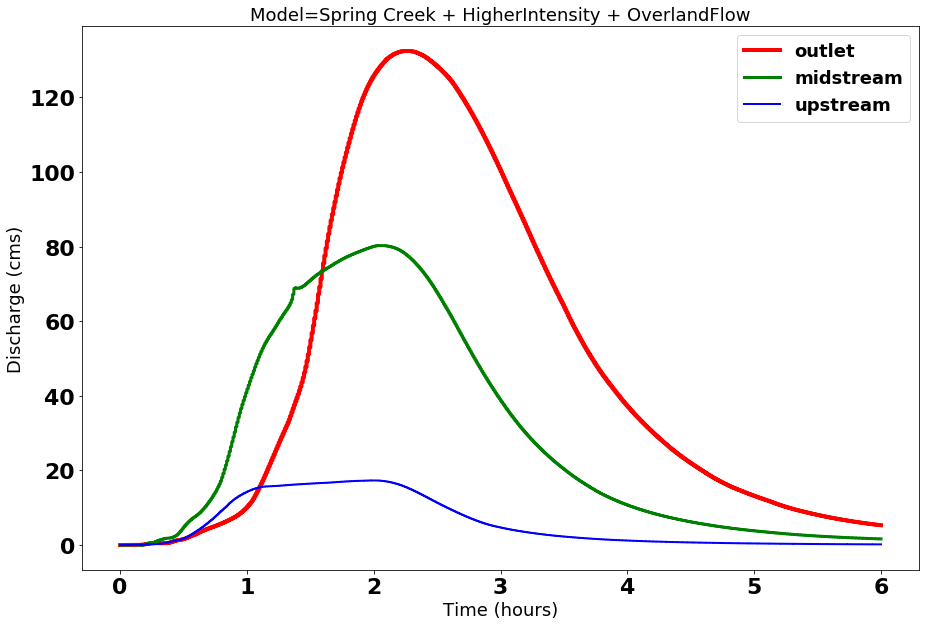

In [50]:
hydrograph_fig = plt.figure(figsize=(15, 10))

# Plot hydrograph series.
plt.plot(hydrograph_time, discharge_at_outlet, 'r-', label='outlet', linewidth=4)
plt.plot(hydrograph_time, discharge_midstream, 'g-', label='midstream',linewidth=3)
plt.plot(hydrograph_time, discharge_upstream, 'b-', label='upstream',linewidth=2)

# Configure plot elements.
plt.ylabel('Discharge (cms)', fontsize=18)
plt.xlabel('Time (hours)', fontsize=18)
plt.legend(loc='upper right', fontsize=18)
title_text = 'Model=' + str(basin_flag) + ' + ' + str(storm_flag) + ' + ' + routing_method
plt.title(title_text, fontsize=18)


#plt.savefig(basin_flag + '_' + storm_flag + '_' + routing_method + '_hydrograph.png', format='png', dpi=1000)

### 6.2. Show map for one model result at the time step of interest to you 

The code you ran above produced image files of model output. 

List the available image files printed in each model run. The files have a naming structure that includes the model time. Note that you will need to change the last line of the code block below get the file names for a given model.



In [51]:
print('Image file names:\n')

# Change the shell script below to list all file names for a png based on your model (e.g., *png, Spring*png, or Square*png)
!ls Spring*png

Image file names:

Spring Creek_HigherIntensity_KinwaveImplicitOverlandFlow_0.0hr_map.png
Spring Creek_HigherIntensity_KinwaveImplicitOverlandFlow_1.0hr_map.png
Spring Creek_HigherIntensity_KinwaveImplicitOverlandFlow_1.33333333333hr_map.png
Spring Creek_HigherIntensity_KinwaveImplicitOverlandFlow_2.0hr_map.png
Spring Creek_HigherIntensity_KinwaveImplicitOverlandFlow_2.66666666667hr_map.png
Spring Creek_HigherIntensity_KinwaveImplicitOverlandFlow_3.0hr_map.png
Spring Creek_HigherIntensity_KinwaveImplicitOverlandFlow_4.0hr_map.png
Spring Creek_HigherIntensity_KinwaveImplicitOverlandFlow_5.0hr_map.png
Spring Creek_HigherIntensity_KinwaveImplicitOverlandFlow_5.33333333333hr_map.png
Spring Creek_HigherIntensity_KinwaveImplicitOverlandFlow_6.66666666667hr_map.png
Spring Creek_HigherIntensity_KinwaveImplicitOverlandFlow_hydrograph.png
Spring Creek_HigherIntensity_OverlandFlow_0.0hr_map.png
Spring Creek_HigherIntensity_OverlandFlow_1.0hr_map.png
Spring Creek_HigherIntensity_OverlandFlow_2.0hr

Choose and visualize the image file by changing the name of the image input to be consistent with the name of a image listed above. 

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


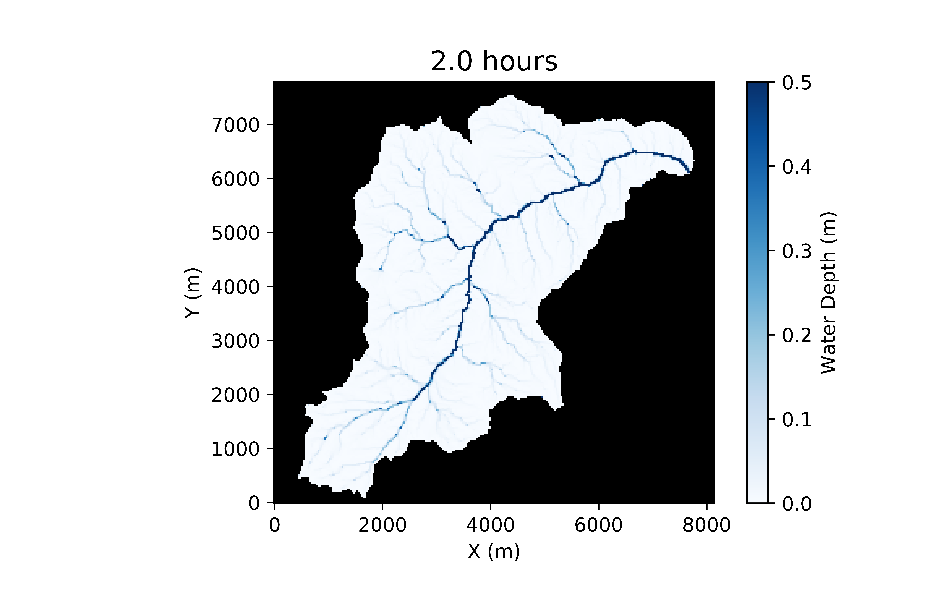

In [52]:
img = mgimg.imread(fname='Spring Creek_HigherIntensity_KinwaveImplicitOverlandFlow_2.0hr_map.png')
img = mgimg.imread(fname='Spring Creek_HigherIntensity_OverlandFlow_2.0hr_map.png')
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(img)
_ = plt.axis('off')

### 6.3. Save model results into a text file at the end of each model run 

If you want to explore the hydrographs created in this application in another software environment, you will run the code below to create a single .csv file that contains modeled hydrograps at each location in the watershed. Please run this code for each run you completed separately. The .csv file can be used in Excel, Matlab or any other software. The name of the new file will be printed.  

In [41]:
modeldata = pd.DataFrame()
modeldata['Timestep'] = hydrograph_time
modeldata['outlet'] = discharge_at_outlet
modeldata['midstream'] = discharge_midstream
modeldata['upstream'] = discharge_upstream
header = {'Timestep', 'Outlet_cms', 'Midstream_cms', 'Upstream_cms'}
modeldata.to_csv(str(basin_flag + '_' + storm_flag + '_' + routing_method  + '_flow.csv'), index=False, header=header, sep=',')

In [43]:
print('The code you ran above produced image files of model output.')
print('The files have a naming structure that includes the model time. The files:')

# Change the shell script below to list all the file names for a png based on your model (e.g., *png, Spring*png, or Square*png).
!ls *csv

print('To download this file, go to the File Dashbard and browse the JupyterHub server')

The code you ran above produced image files of model output.
The files have a naming structure that includes the model time. The files:
Spring Creek_HigherIntensity_KinwaveImplicitOverlandFlow_flow.csv
To download this file, go to the File Dashbard and browse the JupyterHub server



**You completed the tutorial to run the model. You can now explore different routing methods and model parameters  by editing and re-executing sections by making model decisions (4.0), running the model (5.0) and saving results (6.0). Repeat as many model runs as you like and save all of your results before you start comparing results.**  



## 7.0. Discussion 

In this section you will visualize results from your model runs to compare results obtained in the two study watersheds and begin writing your observations from model runs. In this section you may also generate more research questions to explore with the two models. You will also see how the two methods can yield different results.

### 7.1. Plot maps of water depth for two model runs  

Choose two image files printed in each animation increment **from two different models** to compare at a timestep that is most interesting. 

**Note:** You will get the error `No such file or directory` following the code block below if you have not run the `OverlandFlow` option of the `routing_method`. In summary, you must the routing method, rerun the model, then the code block below can be run successfully.

In [ ]:
hydrograph_fig = plt.figure(figsize=(20, 18))
ax1 = hydrograph_fig.add_subplot(221)
fname1 = 'Spring Creek_HigherIntensity_KinwaveImplicitOverlandFlow_2.0hr_map.png'
img1 = mgimg.imread(fname1)
imgplot = plt.imshow(img1)
ax1.axis('off')

# Plotting the hydrographs from the Spring Creek DEM at the outlet
ax2 = hydrograph_fig.add_subplot(222)
fname2 = 'Spring Creek_HigherIntensity_OverlandFlow_2.0hr_map.png'
img2 = mgimg.imread(fname2)
imgplot = plt.imshow(img2)
ax2.axis('off')

### 7.2. Plot hydrographs for two model runs  

In [ ]:
!ls -lt *_hydrograph.png

In [ ]:
hydrograph_fig = plt.figure(figsize=(20, 20))
ax1 = hydrograph_fig.add_subplot(221)
fname1 = 'Spring Creek_HigherIntensity_KinwaveImplicitOverlandFlow_hydrograph.png'
img1 = mgimg.imread(fname1)
imgplot = plt.imshow(img1)
ax1.axis('off')

# Plot the hydrographs from the Spring Creek DEM at the outlet.
ax2 = hydrograph_fig.add_subplot(222)
fname2 = 'Spring Creek_HigherIntensity_OverlandFlow_hydrograph.png'
img2 = mgimg.imread(fname2)
imgplot = plt.imshow(img2)
ax2.axis('off')

## 8.0. Conclusions

At this point in the notebook, you should have produced a plot of three hydrographs from different points in the Spring Creek watershed, produced from overland flow driven by the base storm.

There are six scenarios to explore: two different watersheds and three different storms, if you use the default parameters. If you explore different Manning's roughness values run all six scenarios by systematically changing the `basin_flag` and `storm_flag` in Code Block 2 and rerunning all of the code blocks sequentially. Save the hydrograph plots for each scenario. 

### Directions if you are using this as a laboratory exercise

Include those plots in a document that also contains your typed answers to each of the questions below. Answer all of the questions with complete sentences. Try to be as specific and as quantitative as you can. For example, you can compare times to peak discharge and peak discharge values among the scenarios. You are encouraged to discuss the results of the models with your classmates, but the text you turn in must be your own thoughts and words.

1. What aspects of the hydrograph change at the outlet as the storm gets longer or more intense? Are there aspects of the outlet hydrograph that are not sensitive to the storm duration or intensity? Do the midstream and upstream hydrographs exhibit the same sensitivity to storm duration and intensity? Explain why.  

2. What are the differences in the hydrograph response in the outlets of the two watersheds? How does the watershed shape influence the hydrograph shape?

3. Now compare the hydrograph shapes across the three different locations in the watersheds. Compare only between similar points (e.g. mid or upstream locations) and between the same storm characteristics. How does watershed shape affect hydrograph shape? Does it impact all locations in the same manner? Do different storm characteristics exaggerate the differences between the different watersheds?

4. Now compare the results between the two different watershed. How different are hydrograph characteristics between the square and natural watershed (Spring Creek)?

5. Please compare your answers to the questions you answered before running the models. Do the model results match your intuition? If not, do you think your intuition was wrong, or the model was wrong, or both? Remember, models are helpful for learning but they are highly simplified representations of the real world. Without knowing the details of the model, does it seem like something is missing from your model results?

## 9.0. Save the results in HydroShare
<a name="creation"></a>

Using the HydroShare utilities library, the results of the Geoprocessing steps above can be saved in HydroShare.  First, define all of the required metadata for resource creation, i.e. *title*, *abstract*, *keywords*, *content files*.  In addition, we must define the type of resource that will be created, in this case *genericresource*.

### 9.1. List files to export to new HydroShare resource
The name of files listed below need to be consistent with what exists in your file directory

In [ ]:
ThisNotebook = 'explore_routing_tutorial.ipynb' # check name for consistency
modelresults = 'Square_HigherIntensity_OverlandFlow_flow.csv'
animation = 'animation.mp4'
hydrograph ='Square_HigherIntensity_OverlandFlow_3.0hr_map.png'

files = [ThisNotebook, modelresults, animation, hydrograph]

### 9.2. Generate a new HydroShare resource with Title, Abstract, Keyword and files (listed above)

The metadata can be edited from HydroShare once the new resource is created.  

In [ ]:
# For each file downloaded onto the server folder, move to a new HydroShare Generic Resource.
title = 'Test Delete'
abstract = 'abstract text '
keywords = ['Landlab', 'routing'] 
rtype = 'genericresource'  

# Create the new resource.
resource_id = hs.createHydroShareResource(abstract, 
                                          title,
                                          keywords=keywords, 
                                          resource_type=rtype, 
                                          content_files=files, 
                                          public=False)

## 10.0 Clean up—be a good community data steward—thank you!
Check that all of the files you want are saved on HydroShare. Then use shell scripting from the Notebook to view and delete data.  


In [ ]:
# Print current working directory and make sure you are in the directory you want to clean up.
!pwd

# List files in directory with date of creation. Check that you do not need any of these files. 
!ls -lt 

In [ ]:
# Remove all files you created. This will not remove the Notebook you are using now.   
!rm *png
!rm *mp4
!rm *csv

# List everything remaining in the folder - this should be only what you downloaded from
# HydroShare. Note that all of this will be overwritten the next time you `Open With`
# from the HydroShare webpage for this resource, execute the Welcome page, and answer
# ‘Yes’ to download the data again from HydroShare.  
!ls -lt